Luana Rauber Sostisso, Matheus Azevedo e Gabriel Ottonelli

## Trabalho 1 - Wikipedia Pessoas

In [ ]:
import os
import re
import requests
import time
import threading
from bs4 import BeautifulSoup
from queue import Queue
from queue import Empty as QueueEmpty
from urllib.parse import urljoin, unquote
import shutil

In [ ]:
# --- Configurações Iniciais ---
URL_BASE = "https://pt.wikipedia.org"
URL_INICIAL = urljoin(URL_BASE, "/wiki/Wikipédia:Página_principal")
HEADERS = {"User-Agent": "Mozilla/5.0"}
PASTA_OUTPUT = "LINKS_PESSOAS"
TARGET_COUNT = 1000
NUM_THREADS = 10 # para o uso em versao paralela

# --- Estruturas de Dados ---
fila_prioritaria = Queue()             # lista de links que foram extraidos de paginas que pertenciam a pessoas
fila_normal = Queue()                  # lista de links extraidos de paginas que nao sao de pessoas
visitados = set()                      # lista de links visitados, nao visitamos links repetidos
links_pessoas_encontrados = []         # lista de links que foram extraidos de paginas que pertenciam a pessoas
data_lock = threading.Lock()           # estrutura de lock do python

In [12]:
# --- Funcoes ---
def eh_pagina_de_pessoa(soup):
    infobox = soup.find("table", {"class": "infobox_v2"})
    if not infobox:
      infobox = soup.find("table", {"class": "infobox"})
    if not infobox:
      infobox = soup.find("table", {"class": "infobox infobox_v2"})

    if infobox:
        cabecalhos = infobox.find_all("th")
        for th in cabecalhos:
            if "Nascimento" in th.get_text():
                return True
    return False

def extrair_links_validos(soup):
    """Extrai todos os links internos de artigos da Wikipédia de uma página."""
    links_encontrados = set()
    for link in soup.find_all("a", href=re.compile(r"^(/wiki/)((?!:).)*$")):
        href = link.get("href")
        if href:
            url_completa = urljoin(URL_BASE, href)
            links_encontrados.add(url_completa)
    return list(links_encontrados)

def salvar_pagina_pessoa(url_pessoa, conteudo_html):
    """
    Salva o conteúdo HTML de uma página de pessoa em um arquivo.
    """
    try:
        nome_base = url_pessoa.split('/wiki/')[-1] # Extrai o nome do link, no padrao Wiki eh a parte final do link
        caminho_completo = os.path.join(PASTA_OUTPUT, (nome_base).strip() + '.html')

        with open(caminho_completo, "wb") as arquivo: # wb (write bytes) pq resposta.content é uma sequência de bytes
            arquivo.write(conteudo_html)

        print(f"   --> Arquivo salvo: {caminho_completo}")

    except Exception as e:
        print(f"   --> ERRO ao salvar o arquivo para a URL {url_pessoa}: {e}")

In [ ]:
# --- Criacao de pasta para salvar, se a pasta tem coisas -> limpa ---
if os.path.exists(PASTA_OUTPUT):
    shutil.rmtree(PASTA_OUTPUT)

os.makedirs(PASTA_OUTPUT, exist_ok=True)
print(f"Pasta '{PASTA_OUTPUT}' criada")

Pasta 'LINKS_PESSOAS' criada


In [ ]:
print(f"Iniciando busca a partir de: {URL_INICIAL}")

# a partir da pagina inicial popular a lista fila_normal
try:
    resposta = requests.get(URL_INICIAL, headers=HEADERS, timeout=10)
    soup = BeautifulSoup(resposta.content, "html.parser")
    links_iniciais = extrair_links_validos(soup)
    for link in links_iniciais:
        if link not in visitados:
            fila_normal.put(link)
            visitados.add(link)
    print(f"Encontrados {len(links_iniciais)} links na página principal")
except requests.RequestException as e:
    print(f"Erro ao acessar a página inicial: {e}.")


Iniciando busca a partir de: https://pt.wikipedia.org/wiki/Wikipédia:Página_principal
Encontrados 116 links na página principal


##### Criamos duas versoes do trabalho, uma em paralelo usando threads e outra sequencial. Ambas fazem a mesma funcao, mas como o numero de pessoas a serem extraidas era grande, tivemos que usar a versao paralela para coletar os links

## Versao Paralela usando Threads


In [ ]:
"""Função que cada thread executará para processar as páginas."""
def worker():
    global visitados
    global links_pessoas_encontrados
    global visited_count

    while True:
        with data_lock:
            if len(links_pessoas_encontrados) >= TARGET_COUNT:
                break
        try:
            pagina_atual = fila_prioritaria.get_nowait()
            fonte = "PRIORITÁRIA"
        except QueueEmpty:
            try:
                pagina_atual = fila_normal.get_nowait()
                fonte = "NORMAL"
            except QueueEmpty:
                time.sleep(0.3)
                # Se a execução chegou a este ponto, significa que tanto a fila prioritária quanto a normal
                # estão vazias. Em vez de deixar a thread em um loop infinito (busy-waiting),
                # o que consumiria recursos de CPU desnecessariamente, fazemos uma pequena pausa.
                #
                # Esta pausa de 0.3 segundos é uma aposta de que, nesse meio tempo, outras threads
                # ativas encontrarão e adicionarão novos links às filas.
                #
                # Embora não seja a solução mais otimizada (que seria usar 'fila.get()' bloqueante),
                # ela é funcional, simples de entender e adequada para a escala deste crawler.
                continue

        with data_lock:
            visited_count += 1

        print(f"[{threading.current_thread().name}] Visitando ({fonte}): {pagina_atual}")

        try:
            resposta = requests.get(pagina_atual, headers=HEADERS, timeout=10)
            conteudo_pagina = resposta.content
            soup_pagina = BeautifulSoup(conteudo_pagina, "html.parser")

            if eh_pagina_de_pessoa(soup_pagina):
                print(f"PESSOA ENCONTRADA! -> {pagina_atual} por [{threading.current_thread().name}]")

                with data_lock:
                    if len(links_pessoas_encontrados) < TARGET_COUNT:
                        links_pessoas_encontrados.append(pagina_atual)
                        count = len(links_pessoas_encontrados)
                        print(f"---------- Progresso: {count}/{TARGET_COUNT} ----------")
                    else:
                        continue

                salvar_pagina_pessoa(pagina_atual, conteudo_html=conteudo_pagina)

                novos_links = extrair_links_validos(soup_pagina)
                for link in novos_links:
                    with data_lock:
                        if link not in visitados:
                            visitados.add(link)
                            fila_prioritaria.put(link)
            else:
                novos_links = extrair_links_validos(soup_pagina)
                for link in novos_links:
                    with data_lock:
                        if link not in visitados:
                            visitados.add(link)
                            fila_normal.put(link)
            time.sleep(0.1)

        except requests.RequestException as e:
            print(f"  -> [{threading.current_thread().name}] Erro de request em {pagina_atual}: {e}")
        except Exception as e:
            print(f"  -> [{threading.current_thread().name}] Erro inesperado em {pagina_atual}: {e}")

In [ ]:
# Trecho para executar versao paralela, se for executar sequencial, nao rode
visited_count = 0

threads = []
for i in range(NUM_THREADS):
    thread = threading.Thread(target=worker, name=f"Thread-{i+1}")
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

proportion = len(links_pessoas_encontrados) / visited_count if visited_count > 0 else 0
print(f"\n--- Versão Paralela ---")
print(f"Total de páginas de pessoas encontradas: {len(links_pessoas_encontrados)}")
print(f"Total de páginas visitadas: {visited_count}")
print(f"Proporção de páginas coletadas / páginas visitadas: {proportion:.4f}")

Streaming output truncated to the last 5000 lines.
   --> Arquivo salvo: LINKS_PESSOAS/Zhang_Wentian.html
[Thread-5] Visitando (PRIORITÁRIA): https://pt.wikipedia.org/wiki/Zhang_Xueliang
[Thread-9] Visitando (PRIORITÁRIA): https://pt.wikipedia.org/wiki/Anti-imperialista
[Thread-10] Visitando (PRIORITÁRIA): https://pt.wikipedia.org/wiki/Margem_da_%C3%81gua
[Thread-4] Visitando (PRIORITÁRIA): https://pt.wikipedia.org/wiki/Wang_Fuzhi
[Thread-3] Visitando (PRIORITÁRIA): https://pt.wikipedia.org/wiki/Qufu[Thread-6] Visitando (PRIORITÁRIA): https://pt.wikipedia.org/wiki/Jonathan_Spence

PESSOA ENCONTRADA! -> https://pt.wikipedia.org/wiki/Nikita_Kruchov por [Thread-8]
---------- Progresso: 455/1000 ----------
   --> Arquivo salvo: LINKS_PESSOAS/Nikita_Kruchov.html
[Thread-9] Visitando (PRIORITÁRIA): https://pt.wikipedia.org/wiki/Segunda_Frente_Unida
[Thread-1] Visitando (PRIORITÁRIA): https://pt.wikipedia.org/wiki/O_Esp%C3%ADrito_das_Leis
PESSOA ENCONTRADA! -> https://pt.wikipedia.org/wiki/Zh

## Versao sequencial

In [ ]:
visited_count = 0

while len(links_pessoas_encontrados) < TARGET_COUNT:
    if fila_prioritaria.empty() and fila_normal.empty():
        print("As filas de links estao vazias. Encerrando a busca.")
        break

    if not fila_prioritaria.empty():
        pagina_atual = fila_prioritaria.get()
        fonte = "PRIORITÁRIA"
    else:
        pagina_atual = fila_normal.get()
        fonte = "NORMAL"

    visited_count += 1

    print(f"[{len(links_pessoas_encontrados)}/{TARGET_COUNT}] Visitando ({fonte}): {pagina_atual}")

    try:
        resposta = requests.get(pagina_atual, headers=HEADERS, timeout=10)
        conteudo_pagina = resposta.content
        soup_pagina = BeautifulSoup(resposta.content, "html.parser")

        if eh_pagina_de_pessoa(soup_pagina):
            print(f"PESSOA ENCONTRADA! -> {pagina_atual}")
            links_pessoas_encontrados.append(pagina_atual)
            salvar_pagina_pessoa(pagina_atual, conteudo_html=conteudo_pagina)
            novos_links = extrair_links_validos(soup_pagina)
            for link in novos_links:
                if link not in visitados:
                    fila_prioritaria.put(link)
                    visitados.add(link)
        else:
            novos_links = extrair_links_validos(soup_pagina)
            for link in novos_links:
                if link not in visitados:
                    fila_normal.put(link)
                    visitados.add(link)
        time.sleep(0.1)
    except requests.RequestException as e:
        print(f"  -> Erro ao acessar {pagina_atual}: {e}")
        continue
    except Exception as e:
        print(f"  -> Ocorreu um erro inesperado ao processar {pagina_atual}: {e}")
        continue


print(f"\n--- Versão Sequencial ---")
print(f"Total de pessoas encontradas: {len(links_pessoas_encontrados)}")
print(f"Total de páginas visitadas: {visited_count}")
proportion = len(links_pessoas_encontrados) / visited_count if visited_count > 0 else 0
print(f"Proporção de páginas coletadas / páginas visitadas: {proportion:.4f}")

### Baixar arquivos do colab

In [ ]:
from google.colab import files
import shutil

shutil.make_archive("LINKS_PESSOAS", "zip", "/content/LINKS_PESSOAS")
files.download("LINKS_PESSOAS.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Trabalho 1 - Tarefa 2 - 6 Graus de Separação

### Para encontrar o caminho mais proximo usamos busca por largura
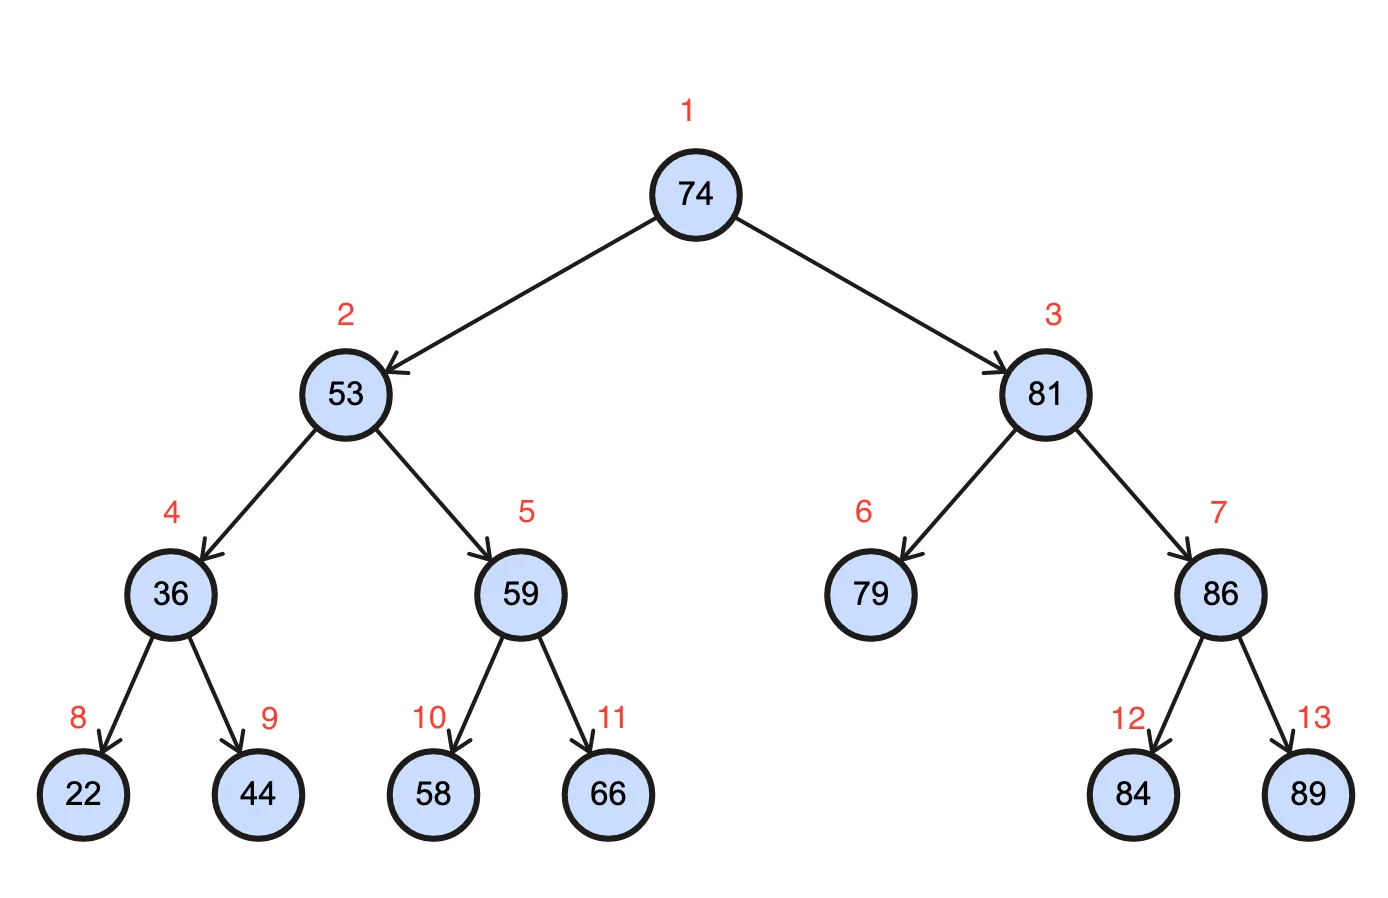

Faz sentido pois queremos achar a ligacao mais curta entre dois nodos.

##### Para rodar essa parte do trabalho, voce deve ter a pasta LISTA_PESSOAS populada, deve ter rodado a celula de definicoes de variaveis e de funcoes da parte 1.

In [23]:
import os
from urllib.parse import unquote
from collections import deque

In [43]:
# --- Escolha de duas pessoas para a busca ---
output_files = [f for f in os.listdir(PASTA_OUTPUT) if f.endswith(".html")]
num_files = len(output_files)

print(f"Escolha 2 numeros entre 1 e {num_files}")
print("Escolha o primeiro numero")
num_1 = int(input())
print("Escolha o segundo numero")
num_2 = int(input())

if not (1 <= num_1 <= num_files) or not (1 <= num_2 <= num_files):
    print("Numeros invalidos. Por favor, escolha numeros dentro do intervalo especificado.")
else:
    filename_1 = output_files[num_1 - 1]
    filename_2 = output_files[num_2 - 1]

    url_pessoa_1 = urljoin(URL_BASE, "/wiki/" + os.path.splitext(filename_1)[0])
    url_pessoa_2 = urljoin(URL_BASE, "/wiki/" + os.path.splitext(filename_2)[0])


    print(f"\nPessoa 1: {url_pessoa_1}")
    print(f"Pessoa 2: {url_pessoa_2}")


Escolha 2 numeros entre 1 e 1000
Escolha o primeiro numero
628
Escolha o segundo numero
1

Pessoa 1: https://pt.wikipedia.org/wiki/Abdoulaye_Wade
Pessoa 2: https://pt.wikipedia.org/wiki/Ralph_Johnson_Bunche


⚠️ **Importante**

Atualmente, o grafo é criado com todos os links encontrados em cada página de pessoa, sem verificar se os nós realmente representam pessoas (conforme a teoria de Stanley Milgram).

Para garantir que as conexões sejam feitas apenas entre pessoas:
1. Preencha a variável **`links_pessoas_encontrados`** executando a **Parte 1 do trabalho**.  
2. Descomente a linha de verificação indicada no código.  
3. Ajuste a indentação do comando seguinte para manter a lógica correta.


In [35]:
# --- Criacao do grafo com ligacoes ---

grafo_pessoas = {}

for nome_arquivo in os.listdir(PASTA_OUTPUT):
    if nome_arquivo.endswith(".html"):
        caminho_completo_arquivo = os.path.join(PASTA_OUTPUT, nome_arquivo)
        nome_pagina = os.path.splitext(nome_arquivo)[0]
        url_pagina_atual = urljoin(URL_BASE, "/wiki/" + nome_pagina)

        with open(caminho_completo_arquivo, "r", encoding="utf-8") as f:
            conteudo_html = f.read()

        soup_pagina = BeautifulSoup(conteudo_html, "html.parser")
        links_internos = set(extrair_links_validos(soup_pagina))  # Extrai todos os links e armazena em um conjunto

        grafo_pessoas[url_pagina_atual] = set()

        for link in links_internos:
            nome_link_codificado = link.split('/wiki/')[-1]       # Extrai a parte final do link - nome da página
            url_link_completa = urljoin(URL_BASE, "/wiki/" + nome_link_codificado)
            #if url_link_completa in links_pessoas_encontrados:
            grafo_pessoas[url_pagina_atual].add(url_link_completa)

print(f"Grafo de pessoas construído com {len(grafo_pessoas)} nós.")

Grafo de pessoas construído com 1000 nós.


In [44]:
# --- Funcao para encontrar as ligacoes entre os links ---
def grau_separacao(grafo, start_url, end_url):
    """
    Calcula o grau de separação (caminho mais curto) entre duas URLs em um grafo.

    Args:
        grafo (dict): O grafo representando as conexões entre as páginas.
        start_url (str): A URL de início.
        end_url (str): A URL de destino.

    Returns:
        tuple: Uma tupla contendo o grau de separação (int) e o caminho
               (list de strings) se um caminho for encontrado, caso contrário, None.
    """
    if start_url not in grafo or end_url not in grafo:
        return None

    fila = deque([(start_url, [start_url])])                    # Fila para BFS: (url_atual, caminho_atual)
    visitados_bfs = {start_url}                                 # Conjunto para rastrear nós ja visitados

    while fila:
        (url_atual, caminho_atual) = fila.popleft()             # Remove o primeiro elemento da fila

        if url_atual == end_url:                                # Verifica se achamos o alvo
            return len(caminho_atual) - 1, caminho_atual        # Grau de separação e o caminho

        if url_atual in grafo:                                  # Se a página atual existe no grafo
            for vizinho in grafo[url_atual]:                    # Percorre todas as páginas vizinhas (conectadas)
                if vizinho not in visitados_bfs:                # Se ainda não foi visitada
                    visitados_bfs.add(vizinho)                  # Marca como visitada

                    novo_caminho = list(caminho_atual)          # Copia o caminho atual
                    novo_caminho.append(vizinho)                # Adiciona o vizinho

                    fila.append((vizinho, novo_caminho))        # Coloca na fila da BFS, vai olhar depois



    return None                                                 # Nenhum caminho foi encontrado


In [45]:
# --- Rodar a busca ---
resultado = grau_separacao(grafo_pessoas, url_pessoa_1, url_pessoa_2)

print("------- BUSCA ENTRE: ----------")
print(url_pessoa_1)
print(url_pessoa_2)


if resultado is not None:
    grau, caminho = resultado
    print(f"\nGrau de separação: {grau}")
    print("Caminho encontrado:")
    for url in caminho:
        print(url)
else:
    print("\nNão foi possível encontrar um caminho entre as pessoas selecionadas.")

------- BUSCA ENTRE: ----------
https://pt.wikipedia.org/wiki/Abdoulaye_Wade
https://pt.wikipedia.org/wiki/Ralph_Johnson_Bunche

Grau de separação: 2
Caminho encontrado:
https://pt.wikipedia.org/wiki/Abdoulaye_Wade
https://pt.wikipedia.org/wiki/Martti_Ahtisaari
https://pt.wikipedia.org/wiki/Ralph_Johnson_Bunche
